# Extracting Drug Targets from Drugbank

In [455]:
# data downloaded from:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742

# CMAP data User Guide: 
# https://docs.google.com/document/d/1q2gciWRhVCAAnlvF2iRLuJ7whrGP6QjpsCMq1yWz7dU/

import xmltodict
from pprint import pprint
import pandas as pd
import numpy as np
import itertools
from cmapPy.pandasGEXpress import parse

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [4]:
drugbank_db = xmltodict.parse(open('full drugbank_database.xml').read())
drug0 = drugbank_db['drugbank']['drug'][0]
drug0 # an example drug in OrderedDict format

OrderedDict([('@type', 'biotech'),
             ('@created', '2005-06-13'),
             ('@updated', '2017-11-06'),
             ('drugbank-id',
              [OrderedDict([('@primary', 'true'), ('#text', 'DB00001')]),
               'BTD00024',
               'BIOD00024']),
             ('name', 'Lepirudin'),
             ('description',
              'Lepirudin is identical to natural hirudin except for substitution of leucine for isoleucine at the N-terminal end of the molecule and the absence of a sulfate group on the tyrosine at position 63. It is produced via yeast cells. Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.'),
             ('cas-number', '138068-37-8'),
             ('unii', 'Y43GF64R34'),
             ('state', 'liquid'),
             ('groups', OrderedDict([('group', 'approved')])),
             ('general-references',
              OrderedDict([('articles',
                            OrderedDict([('article',
                            

The original Drugbank database is stored in XML format, which we've converted to an ordered dictionary. This database contains a top of information that we don't need, so our first goal is to create a stripped-down dictionary of drug-target pairings that we can use to lookup the targets of drugs tested in the LINCS library. This dictionary will have the drugs' InChiKeys as Keys and the targets' Hugo Gene Symbol as values. 

*In the future we may want to use additional metadata from the DrugBank database, such as whether the drugs are inhibitors or activators.*

First we need to clean the data, as the target names are difficult to extract for several reasons: 

* Some drugs are not small molecules but polymers or other macromolecules we are not interested in
* Some drugs have multiple targets with their names stored in a list structure rather than an ordered dictionary
* Some drugs target protein complexes, composed of multiple distinct proteins with different names
* Some target names are missing

The code below contains contains many checks to account for the complexities listed above:

In [5]:
drug_target_dict = {}

# all drugs are OrderedDicts 
for drug in o['drugbank']['drug']:
    
    # limit analysis to small molecules (n=9292), ignore type 'biotech' (n=1213)
    if drug['@type'] == 'small molecule':
        calc_props = drug['calculated-properties']
        
        # find the InchiKey for the drug
        # n=576 cpds have 'NoneType' props
        # the rest are OrderedDicts w/ exactly one key: 'property'
        if calc_props: 
            props = calc_props['property'] 
            # props is usually a list of OrderedDicts, each with keys 'kind', 'value', and 'source'
            # DB11635 is an exception, for which props is not a list, but a single OrderedDict with no Inchi
            if type(props) == type([]):
                inchi_list = [ prop['value'] for prop in props if prop['kind'] == 'InChIKey' ]
                # all cpds have either 1 or 0 inchi_keys
                if len(inchi_list) > 0:
                    inchi_key = inchi_list[0]
                    gene_targets = []
                    
                    # Now we have to lookup the drug targets. 
                    # All drugs have a 'target' field, but n=2259 have are NoneType
                    targets = drug['targets']
                    if targets: # (n=6455) targets is an OrderedDict with one key: 'target'
                        target = targets['target'] # can either be an OrderedDict or a list of OrderedDicts
                        
                        # target is an OrderedDict (n=4152)
                        if type(target) == type(drug0): 
                            # some targets are not proteins (eg: DNA, RNA, ribosome)
                            # we'll only pay attention to protein targets 
                            if 'polypeptide' in target.keys():
                                polypeptide = target['polypeptide'] # polypeptide can be either a list or an OrderedDict
                                
                                # polypeptide is an OrderedDict
                                if type(polypeptide) == type(drug0):
                                    gene_name =  polypeptide['gene-name']
                                    if gene_name and gene_name.isupper(): # restrict to official gene symbols (i.e. not 'pol' or 'HIV protease')
                                        gene_targets.append(gene_name)
                                    
                                # polypeptide is a list of OrderedDicts (n=14)
                                elif type(polypeptide) == type([]):
                                    gene_names = [ poly['gene-name'] for poly in polypeptide ]
                                    gene_targets += gene_names                                    
                                
                        # target is a list of OrderedDicts (n=2303)
                        elif type(target) == type([]):
                            for targ in target:
                                if 'polypeptide' in targ.keys():
                                    polypeptide = targ['polypeptide'] # polypeptide can be either a list or an OrderedDict
                                    
                                    # polypeptide is an OrderedDict
                                    if type(polypeptide) == type(drug0):
                                        gene_name =  polypeptide['gene-name']
                                        if gene_name and gene_name.isupper(): # restrict to official gene symbols (i.e. not 'pol' or 'HIV protease')
                                            gene_targets.append(gene_name)

                                    # polypeptide is a list of OrderedDicts (n=135)
                                    elif type(polypeptide) == type([]):
                                        n +=1
                                        gene_names = [ poly['gene-name'] for poly in polypeptide ]
                                        gene_targets += gene_names          
                        
                    
                    if len(gene_targets) > 0:
                        drug_target_dict[inchi_key] = gene_targets

In [281]:
drugbank_target_dict = drug_target_dict
pprint(drugbank_target_dict)

{'AAKJLRGGTJKAMG-UHFFFAOYSA-N': ['EGFR', 'NR1I2'],
 'AANFHDFOMFRLLR-IBGZPJMESA-N': ['RARG'],
 'AANFHDFOMFRLLR-LJQANCHMSA-N': ['RARG'],
 'AANTYZRUJFNZFI-UHFFFAOYSA-N': ['CA2'],
 'AANXPIMDONQTQF-HNNXBMFYSA-N': ['ADAM17'],
 'AAOVKJBEBIDNHE-UHFFFAOYSA-N': ['GABRA1',
                                 'GABRA2',
                                 'GABRA3',
                                 'GABRA5',
                                 'GABRB1',
                                 'GABRB2',
                                 'GABRB3',
                                 'GABRG1',
                                 'GABRG2',
                                 'GABRG3',
                                 'GABRD',
                                 'GABRE',
                                 'GABRP',
                                 'GABRR1',
                                 'GABRR2',
                                 'GABRR3',
                                 'GABRQ',
                                 'TSPO',
            

 'CJCDMTWCUXKYGF-QPILVHKNSA-N': ['HMGCS1'],
 'CJCSPKMFHVPWAR-JTQLQIEISA-N': ['ADRA2A', 'DDC'],
 'CJDRUOGAGYHKKD-HEFSZTOGSA-N': ['SCN5A'],
 'CJHLRGCXPGIPCB-MOPGFXCFSA-N': ['F2'],
 'CJKKMQCZOLCXAM-UHFFFAOYSA-N': ['AKR1B1'],
 'CJMVTSLLWMPEKQ-INIZCTEOSA-N': ['PPARG'],
 'CJOFXWAVKWHTFT-XSFVSMFZSA-N': ['SLC6A4', 'KCNH2'],
 'CJSSYVIHFXDFFC-UHFFFAOYSA-N': ['FGFR2'],
 'CKBBGCJYKCLKHE-UHFFFAOYSA-N': ['PLAU'],
 'CKJGKHXCUDWFDC-UHFFFAOYSA-N': ['ADA'],
 'CKLAPOFDFZKCPB-LBPRGKRZSA-N': ['GSK3B', 'CAMK4'],
 'CKLJMWTZIZZHCS-REOHCLBHSA-N': ['RNASE1',
                                 'LYZ',
                                 'SLC25A13',
                                 'GOT1',
                                 'ASPA',
                                 'ASNS',
                                 'ASS1',
                                 'ACY1',
                                 'GOT2',
                                 'DARS',
                                 'SLC25A12',
                                 'ASPH',
   

                                 'DCD',
                                 'DSP',
                                 'F12',
                                 'F13B',
                                 'F2',
                                 'FCN3',
                                 'FGA',
                                 'FN1',
                                 'GSN',
                                 'HBA1',
                                 'HBB',
                                 'HPR',
                                 'HRNR',
                                 'IGFALS',
                                 'IGHA1',
                                 'IGHM',
                                 'IGKV1-17',
                                 'IGLV3-21',
                                 'ITIH1',
                                 'ITIH2',
                                 'ITIH3',
                                 'ITIH4',
                                 'JCHAIN',
                                 'JUP',
          

 'LBFDERUQORUFIN-QGZVFWFLSA-N': ['PDPK1'],
 'LBHIOVVIQHSOQN-UHFFFAOYSA-N': ['ABCC9'],
 'LBNVXZROMBUNNQ-SLPGGIOYSA-N': ['GNPDA1'],
 'LBPNOEAFWYTTEB-UHFFFAOYSA-N': ['TP53'],
 'LBTABPSJONFLPO-UWTATZPHSA-N': ['PSPH'],
 'LCBAQTCTQXHTJG-ZETCQYMHSA-N': ['GSK3B'],
 'LCGSYJVWLGYWTD-UHFFFAOYSA-N': ['ESR2', 'NCOA1'],
 'LCMOXIFARISMOH-UHFFFAOYSA-N': ['NOS1'],
 'LCPRWBWCEGWNKF-UHFFFAOYSA-N': ['PTPN1'],
 'LCQLHJZYVOQKHU-VKHMYHEASA-N': ['CPS1'],
 'LCTONWCANYUPML-UHFFFAOYSA-N': ['SLC16A3',
                                 'SLC16A2',
                                 'AGXT2',
                                 'SLC16A5',
                                 'PKLR',
                                 'SLC16A6',
                                 'SLC16A7',
                                 'PDHB',
                                 'PKM',
                                 'ABAT',
                                 'SLC16A4',
                                 'SLC16A8',
                                 'SLC16A1',
        

                                 'CHRM5',
                                 'ADRA2A',
                                 'ADRA2B',
                                 'ADRA2C',
                                 'ADRA1A',
                                 'ADRA1B',
                                 'ADRA1D',
                                 'SLC6A2',
                                 'SLC6A4'],
 'PHVGLTMQBUFIQQ-UHFFFAOYSA-N': ['SLC6A2',
                                 'SLC6A4',
                                 'HTR2A',
                                 'HTR1A',
                                 'HRH1',
                                 'ADRA1A',
                                 'ADRA1D',
                                 'CHRM1',
                                 'CHRM2',
                                 'CHRM3',
                                 'CHRM4',
                                 'CHRM5',
                                 'HTR2C',
                                 'HTR6',
                       

                                 'DHODH'],
 'SYKYBMOFPMXDRQ-ZFDCCPEWSA-N': ['NCAN', 'LGALS1'],
 'SYOKIDBDQMKNDQ-XWTIBIIYSA-N': ['DPP4'],
 'SYRDAPWACIANBN-DPXSRCRQSA-M': ['PGM1'],
 'SYTBZMRGLBWNTM-SNVBAGLBSA-N': ['IKBKG'],
 'SYTBZMRGLBWNTM-UHFFFAOYSA-N': ['PTGS1', 'PTGS2'],
 'SZANYTFSQVBOBA-UHFFFAOYSA-N': ['MAPK14'],
 'SZHOJFHSIKHZHA-UHFFFAOYSA-N': ['PLA2G2A', 'PLA2G1B', 'PLA2G2E'],
 'SZHRIPFGZWWRKW-VIFPVBQESA-N': ['MTHFD1'],
 'SZLZWPPUNLXJEA-QEGASFHISA-N': ['ACE'],
 'SZQIFWWUIBRPBZ-UHFFFAOYSA-N': ['SCN5A', 'NR1I2'],
 'SZUVGMCKKLJAFX-UHFFFAOYSA-N': ['NOS2'],
 'SZYREAUDQRVVLV-DAFNUICNSA-N': ['MAPK10'],
 'TTWJBBZEZQICBI-UHFFFAOYSA-N': ['DRD2', 'CHRM1', 'HTR4', 'HTR3A', 'ACHE'],
 'TUNFSRHWOTWDNC-UHFFFAOYSA-N': ['PKIA',
                                 'PRKACA',
                                 'ECI2',
                                 'RCVRN',
                                 'CALM1',
                                 'ABL1',
                                 'HNF4A',
                        

 'XQAMVCHQGHAELT-YPAWHYETSA-N': ['CELA1', 'ELANE'],
 'XQCKNCFQOJFQFK-UHFFFAOYSA-N': ['PDE4B'],
 'XQFRJNBWHJMXHO-RRKCRQDMSA-N': ['TK'],
 'XQGZSYKGWHUSDH-UHFFFAOYSA-N': ['TBXAS1'],
 'XQKFKSJUBJPOLY-UHFFFAOYSA-N': ['HSP90AA1'],
 'XQKJVNGGVLHNLA-UHFFFAOYSA-N': ['CDK2'],
 'XQKUGFIWKSKCDL-UHFFFAOYSA-N': ['CSNK1G3'],
 'XQTOWNDCHQJXOQ-UHFFFAOYSA-N': ['PYGM'],
 'XQYZDYMELSJDRZ-UHFFFAOYSA-N': ['PDE4B', 'PDE10A'],
 'XRASPMIURGNCCH-UHFFFAOYSA-N': ['FDPS', 'GGPS1'],
 'XRCFXMGQEVUZFC-UHFFFAOYSA-N': ['GGCX'],
 'XRECTZIEBJDKEO-UHFFFAOYSA-N': ['DNMT1', 'TMP1'],
 'XREDUPOVEQDQQS-UHFFFAOYSA-N': ['TYMS'],
 'XRHANBWAKSYPEN-UHFFFAOYSA-N': ['PLAU'],
 'XRJAKERBMMBUGR-UHFFFAOYSA-N': ['GCK'],
 'XRMLXZVSFIBRRJ-PEFMBERDSA-N': ['TK'],
 'XRQDFNLINLXZLB-CKIKVBCHSA-N': ['NA', 'NA', 'NA'],
 'XRSYNYGEEYTXJV-UHFFFAOYSA-N': ['MMP13'],
 'XRWSZZJLZRKHHD-WVWIJVSJSA-N': ['NS3'],
 'XRZABKCMPVBQFX-UGTLBTQMSA-N': ['ATIC'],
 'XSBSKEQEUFOSDD-UHFFFAOYSA-N': ['CHRNA10', 'CHRNA3', 'CHRNB4'],
 'XSBZZZGVAIXJLD-YUMQZZPRSA-N': ['DPP4'],

___
# Cross reference DrugBank targets with LINCS cpds

## Import LINCS Phase 1 MetaData

In [7]:
# cell line information
cell_info = pd.read_csv('GSE92742_Broad_LINCS_cell_info.txt', sep='\t', header=0)
# primary gene symbols and IDs
gene_info = pd.read_csv('GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
# landmark genes
gene_into_delta_lm = pd.read_csv('GSE92742_Broad_LINCS_gene_info_delta_landmark.txt', sep='\t', header=0)
# Metadata pertaining to individual profiles (or instances, experiments) 
inst_info = pd.read_csv('GSE92742_Broad_LINCS_inst_info.txt', sep='\t', header=0, dtype={'pert_dose_unit': str})
# Metadata describing each perturbagen used in experiments (pert_id)
pert_info = pd.read_csv('GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
# Calculated / derived / inferred metrics and annotations associated with each perturbagen that was used in the experiments.
pert_metrics = pd.read_csv('GSE92742_Broad_LINCS_pert_metrics.txt', sep='\t', header=0)
# Metadata for signatures of aggregated replicates (level 5 data)
sig_info = pd.read_csv('GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
# Calculated / derived / inferred metrics and annotations associated with each signature in the Level 5 matrix
sig_metrics= pd.read_csv('GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)

## LINCS perturbation types

<br>The most common types of LINCS perturbations by far are small molecule compounds (trt_cp) and gene knockdowns (trt_sh).

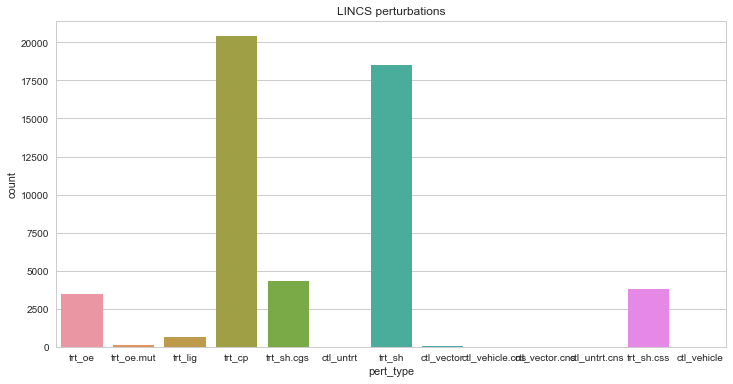

In [466]:
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="pert_type", data=pert_info)
plt.title("LINCS perturbations")
plt.show()

## Refine scope to 'gold' perturbations

Due to redundancy in the LINCS dataset, we can ignore a lot of the low-quality data. We want to focus on **EXEMPLAR** signatures. From the GEO CMap LINCS User Guide:<br><br>
*Due to the redundancy of the CMap database, meaning that some perturbagens have many signatures even within the same cell line, it is convenient to identify a single ‘exemplar’ signature for each perturbagen in each cell line. These signatures are specifically designated for further analysis, such as ICC and aggregate TAS. Exemplar signatures were selected according to the following process. For each perturbagen in each cell line:*
1. *If possible, consider only signatures with between 2 and 6 replicates.*
2. *Within these signatures, select the one with highest transcriptional activity score (TAS). See tas for more details.*
3. *If there are no signatures that have between 2 and 6 replicates, simply select the one with highest TAS.*

We also want to focus on **GOLD** signatures, meaning:<br><br>
*A heuristic for assessing whether a signature is reproducible and distinct. Requirements include: distil_cc_q75 >= 0.2 and pct_self_rank_q25 <= 0.05.*

In [461]:
# n = 473647
all_sig_info = pd.concat([sig_info, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25','is_exemplar']]], axis=1)

# n = 111567
gold_exemplar_sigs = all_sig_info[(all_sig_info['distil_cc_q75'] >= 0.2) 
                         & (all_sig_info['pct_self_rank_q25'] <= 0.05)
                         & (all_sig_info['is_exemplar'].astype(bool))
                        ].reset_index(drop=True)

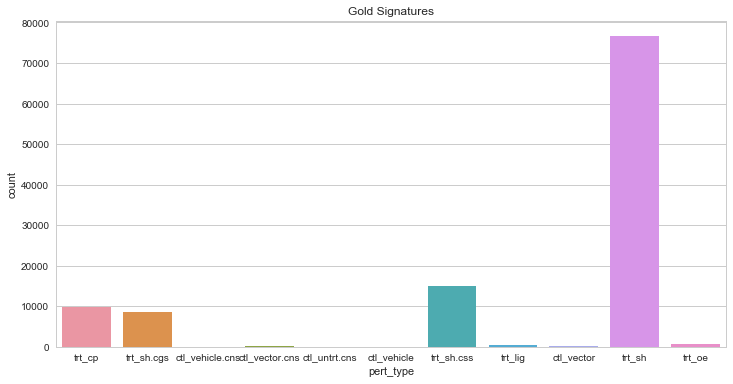

In [465]:
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="pert_type", data=gold_exemplar_sigs)
plt.title("Gold Signatures")
plt.show()

## Extract gold LINCS cpds

In [512]:
# n_gold_cpd_sigs = 9889
# n_gold_cpds = 3157
gold_cpd_sigs = gold_exemplar_sigs[gold_exemplar_sigs['pert_type'] == 'trt_cp'].reset_index(drop=True)

In [530]:
# add inchikeys to table for target lookup
inchi_keys = []
for index, row in gold_cpd_sigs.iterrows():
    pert_id = row['pert_id']
    inchi_key = pert_info[pert_info['pert_id'] == pert_id].iloc[0]['inchi_key']
    inchi_keys.append(inchi_key)
gold_cpd_sigs['inchi_key'] = pd.Series(inchi_keys)

## Lookup DrugBank targets using InchiKeys

In [496]:
pert_ids = []
pert_inames = []
inchi_keys = []
drugbank_targets = []

for index, row in gold_cpd_sigs.iterrows():
    inchi = row["inchi_key"]
    
    # ignore duplicates
    if inchi not in inchi_keys:
    
        if inchi in drugbank_target_dict.keys(): 
            pert_id = row["pert_id"]
            pert_iname = row["pert_iname"]
            targets = drugbank_target_dict[inchi]

            for target in targets:
                pert_ids.append(pert_id)
                pert_inames.append(pert_iname)
                inchi_keys.append(inchi)
                drugbank_targets.append(target)

# create DataFrame and save to file
gold_cpds_db_targets = pd.DataFrame({'pert_id': pd.Series(pert_ids), 
                                        'pert_iname': pd.Series(pert_inames), 
                                        'Drugbank_target': pd.Series(drugbank_targets),
                                        'inchi_key' : pd.Series(inchi_keys)
                                       })
gold_cpds_db_targets.to_csv('gold_cpds_db_targets.csv')
gold_cpds_db_targets.head()

,Drugbank_target,inchi_key,pert_id,pert_iname
0,VDR,GMRQFYUYWCNGIN-NKMMMXOESA-N,BRD-K27316855,calcitriol
1,HOXA10,GMRQFYUYWCNGIN-NKMMMXOESA-N,BRD-K27316855,calcitriol
2,GC,GMRQFYUYWCNGIN-NKMMMXOESA-N,BRD-K27316855,calcitriol
3,TOP2A,STQGQHZAVUOBTE-VGBVRHCVSA-N,BRD-K43389675,daunorubicin
4,TOP2B,STQGQHZAVUOBTE-VGBVRHCVSA-N,BRD-K43389675,daunorubicin


#### 367 unique LINCS cpds with gold signatures have known targets. 
These correspond to 1836 drug-target pairs. Some cpds have many targets.

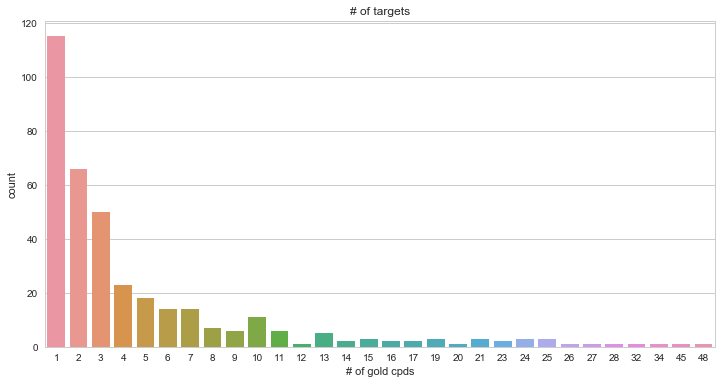

In [509]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_db_targets['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.title("# of targets")
plt.xlabel("# of gold cpds")
plt.show()

Now we need to check whether the targets have also been knocked down in LINCS (and whether these knockdowns have gold signatures), because we want to use profile correlation as one of our features.

## Extract LINCS knockdowns

In [518]:
# n_gold_kd_sigs = 76619
# n_gold_kd_inames = 4344
# n_gold_kd_ids = 15931
gold_kd_sigs = gold_exemplar_sigs[gold_exemplar_sigs['pert_type'] == 'trt_sh'].reset_index(drop=True)
kd_genes = gold_kd_sigs['pert_iname'].unique()

## Filter out cpds w/o targets KDs

In [523]:
gold_cpds_db_targets['target_KD'] = trt_cpds_db_targets['Drugbank_target'].isin(kd_genes)
gold_cpds_db_targets['target_KD'].value_counts()

False    1110
True      726
Name: target_KD, dtype: int64

In [522]:
gold_cpds_w_target_kds = gold_cpds_db_targets[gold_cpds_db_targets['target_KD']].reset_index(drop=True)
len(gold_cpds_w_target_kds['pert_id'].unique())

248

#### 248 unique LINCS cpds with gold signatures have known targets with gold kd signatures.
These correspond to 726 drug-target pairs.

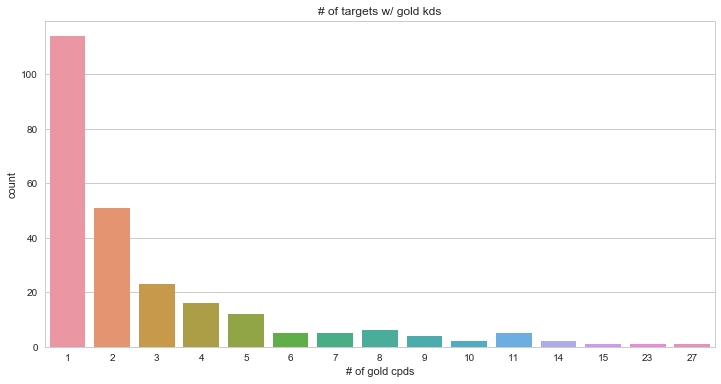

In [524]:
num_target_list = pd.DataFrame({'num_targets': pd.Series(gold_cpds_w_target_kds['pert_id'].value_counts())})
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="num_targets", data=num_target_list)
plt.title("# of targets w/ gold kds")
plt.xlabel("# of gold cpds")
plt.show()

___
# Incorporate Cell line info
<br> We know we have 248 gold compounds with known targets that have their own gold KD signatures. In order to use these signatures for classification we need them to come from the same cell lines.

In [546]:
gold_cpds_w_target_kds['n_common_cells'] = 0
for i in cell_info['cell_id'].values:
    gold_cpds_w_target_kds[i] = False
gold_cpds_w_target_kds.head() # 726 rows    

,Drugbank_target,inchi_key,pert_id,pert_iname,target_KD,n_common_cells,A375,A375.311,A549,A549.311,...,NPC.TAK,HUES3,FIBRNPC,ASC,ASC.C,CD34,PHH,SKB,SKL,SKL.C
0,VDR,GMRQFYUYWCNGIN-NKMMMXOESA-N,BRD-K27316855,calcitriol,True,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,RXRB,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,RARG,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,ALDH1A2,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,RARB,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<br> We want to fill in the columns in the table above showing the number of different cell lines for which we have signatures from both the compound and the target knockdown. Also the boolean columns showing which cell lines were tested. <br><br>

In [552]:
for index, row in gold_cpds_w_target_kds.iterrows():
    cpd_id = row['pert_id']
    target_gene = row['Drugbank_target']
    
    cpd_sigs = gold_cpd_sigs[gold_cpd_sigs['pert_id'] == cpd_id]
    cpd_cells = cpd_sigs['cell_id'].unique()
    
    kd_sigs = gold_kd_sigs[gold_kd_sigs['pert_iname'] == target_gene]
    kd_cells = kd_sigs['cell_id'].unique()
    
    common_cells = np.intersect1d(cpd_cells, kd_cells)
    
    if len(common_cells) > 0:
        gold_cpds_w_target_kds.set_value(index, 'n_common_cells', len(common_cells))
        for cell_line in common_cells:
            gold_cpds_w_target_kds.set_value(index, cell_line, True)

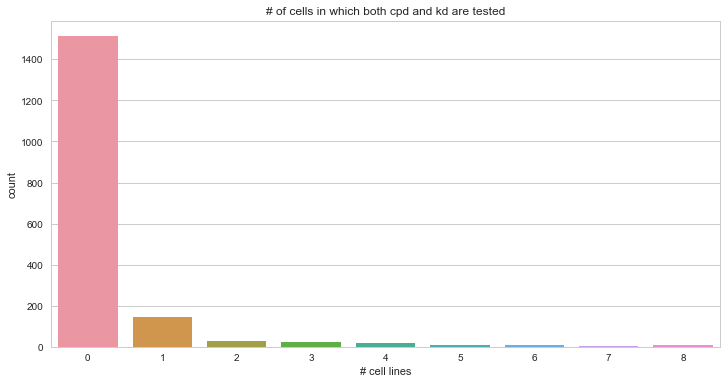

In [553]:
f, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="n_common_cells", data=gold_cpds_w_target_kds)
plt.title("# of cells in which both cpd and kd are tested")
plt.xlabel("# cell lines")
plt.show()

<br>Many cell lines have no drug-target pairs associated with them. We'll remove these from our consideration, leaving us with 13 cell lines remaining.<br><br>

In [549]:
for cell_line in gold_cpds_w_target_kds.columns[6:]:
    if not np.any(gold_cpds_w_target_kds[cell_line]):
        gold_cpds_w_target_kds = gold_cpds_w_target_kds.drop(cell_line, axis=1)
gold_cpds_w_target_kds

,Drugbank_target,inchi_key,pert_id,pert_iname,target_KD,n_common_cells
0,VDR,GMRQFYUYWCNGIN-NKMMMXOESA-N,BRD-K27316855,calcitriol,True,0
1,RXRB,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
2,RARG,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
3,ALDH1A2,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
4,RARB,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
5,RXRA,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
6,HPGDS,SHGAZHPCJJPHSC-YCNIQYBTSA-N,BRD-K71879491,tretinoin,True,0
7,PRKCB,NKANXQFJJICGDU-QPLCGJKRSA-N,BRD-K93754473,tamoxifen,True,0
8,PRKCD,NKANXQFJJICGDU-QPLCGJKRSA-N,BRD-K93754473,tamoxifen,True,0
9,PRKCQ,NKANXQFJJICGDU-QPLCGJKRSA-N,BRD-K93754473,tamoxifen,True,0


___
# Find cell lines with the most drug-target pairs
<br>
Now we know which cell lines each drug(treatment) - target(knockdown) pair has been tested in. Next we need to find the subset of k cell-lines that have the most pairs.
<br><br>

In [370]:
cell_lines = trt_cpds_w_target_kds.columns[6:].values
max_pair_cell_lines = {} # to record cell lines subgroups with max # of pairs for different subgroup sizes
max_cpd_cell_lines = {} # to record cell lines subgroups with max # of unique compounds for different subgroup sizes

for k in range (2,12): # subsets of size k
    max_pair_cell_lines[k] = (0,[],[],None) # (n_common_rows, unique_drugs, common_targets, cell_line_subgroup)
    max_cpd_cell_lines[k] = (0,[],[],None) 
    cell_line_subgroups = list(itertools.combinations(cell_lines,k))
    
    for subgroup in cell_line_subgroups:
        subgroup_cpd_matrix = trt_cpds_w_target_kds[['pert_id', 'Drugbank_target'] + list(subgroup)]
        
        # count number of common cpd-target pairs
        common_pairs = np.logical_and.reduce(subgroup_cpd_matrix[subgroup_cpd_matrix.columns[1:]], axis=1)
        num_common_pairs = np.count_nonzero(common_pairs)
        
        # count number of unique cpds
        true_rows = subgroup_cpd_matrix[common_pairs] # rows in the submatrix with True for all cell lines
        common_cpds = true_rows['pert_id'].unique()
        num_common_cpds = len(common_cpds)
        
        # count number of unique cpds
        common_targets = true_rows['Drugbank_target'].unique()
        num_common_targets = len(common_targets)
        
        # choose max by number of drug-target pairs
        if  num_common_pairs > max_pair_cell_lines[k][0]:        
            max_pair_cell_lines[k] = (num_common_pairs, common_cpds, common_targets, subgroup)
          
        # choose max by number of unique drugs
        if num_common_cpds > len(max_cpd_cell_lines[k][1]):
            max_cpd_cell_lines[k] = (num_common_pairs, common_cpds, common_targets, subgroup)

In [372]:
for i in range(2,12):
    print(i, 
          max_pair_cell_lines[i][0],
          len(max_pair_cell_lines[i][1]),
          len(max_pair_cell_lines[i][2]),
          max_pair_cell_lines[i][3]
         )

2 1416 625 437 ('MCF7', 'PC3')
3 1339 560 407 ('HA1E', 'HT29', 'PC3')
4 1316 556 396 ('A549', 'HA1E', 'HT29', 'PC3')
5 1299 553 393 ('A549', 'HA1E', 'HT29', 'PC3', 'VCAP')
6 1252 536 381 ('A375', 'A549', 'HA1E', 'HT29', 'PC3', 'VCAP')
7 1145 500 371 ('A375', 'A549', 'HA1E', 'HT29', 'MCF7', 'PC3', 'VCAP')
8 984 440 324 ('A375', 'A549', 'HA1E', 'HCC515', 'HT29', 'MCF7', 'PC3', 'VCAP')
9 749 339 287 ('A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'PC3', 'VCAP')
10 144 106 50 ('A375', 'A549', 'HA1E', 'HEPG2', 'HT29', 'MCF7', 'PC3', 'VCAP', 'NPC', 'ASC')
11 128 92 45 ('A375', 'A549', 'HA1E', 'HCC515', 'HEPG2', 'HT29', 'MCF7', 'PC3', 'VCAP', 'NPC', 'ASC')


So the 4 cell lines with the most drug-target pairs in common are ('A549', 'HA1E', 'HT29', 'PC3') and they have 1316 positive examples to learn from, corresponding to 556 unique compounds and 396 unique targets.

We also note that the cell lines with the most cpd-target pairs are also the cell lines with the most unique compounds. This makes sense.
___
# Extract gene expression signatures

We'll start just looking at the 500 unique drugs and the 1145 associated drug-target pairs tested in seven cell lines. Later on we'll expand our analysis to other subsets of cells.

In [414]:
top_7_cell_lines = list(max_pair_cell_lines[7][3])
top_7_cell_line_cpds = max_pair_cell_lines[7][1]
top_7_cell_line_targets = max_pair_cell_lines[7][2]

Due to redundancy in the LINCS dataset, we can ignore a lot of the low-quality data. We want to focus on **EXEMPLAR** signatures. From the GEO CMap LINCS User Guide:<br><br>
*Due to the redundancy of the CMap database, meaning that some perturbagens have many signatures even within the same cell line, it is convenient to identify a single ‘exemplar’ signature for each perturbagen in each cell line. These signatures are specifically designated for further analysis, such as ICC and aggregate TAS. Exemplar signatures were selected according to the following process. For each perturbagen in each cell line:*
1. *If possible, consider only signatures with between 2 and 6 replicates.*
2. *Within these signatures, select the one with highest transcriptional activity score (TAS). See tas for more details.*
3. *If there are no signatures that have between 2 and 6 replicates, simply select the one with highest TAS.*

We also want to focus on **GOLD** signatures, meaning:<br><br>
*A heuristic for assessing whether a signature is reproducible and distinct. Requirements include: distil_cc_q75 >= 0.2 and pct_self_rank_q25 <= 0.05.*
___

## Eliminate redundant signatures

First lets get all the signature info that we need into one dataframe:


In [353]:
all_sig_info = pd.concat([sig_info, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25','is_exemplar']]], axis=1)
all_sig_info.head()

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,distil_cc_q75,pct_self_rank_q25,is_exemplar
0,AML001_CD34_24H:A05,DMSO,DMSO,ctl_vehicle,CD34,0.10000,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:A05,-666.00,-666.00000,0
1,AML001_CD34_24H:A06,DMSO,DMSO,ctl_vehicle,CD34,0.10000,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:A06,-666.00,-666.00000,0
2,AML001_CD34_24H:B05,DMSO,DMSO,ctl_vehicle,CD34,0.10000,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...,0.16,9.06433,0
3,AML001_CD34_24H:B06,DMSO,DMSO,ctl_vehicle,CD34,0.10000,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:B06,-666.00,-666.00000,1
4,AML001_CD34_24H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,CD34,0.37037,µM,500 nM,24,h,24 h,AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...,0.40,4.97076,0


Now extract gold, exemplar signatures:

In [431]:
# n = 111567
gold_exemplar_sigs = all_sig_info[(all_sig_info['distil_cc_q75'] >= 0.2) 
                         & (all_sig_info['pct_self_rank_q25'] <= 0.05)
                         & (all_sig_info['is_exemplar'].astype(bool))
                        ].reset_index(drop=True)

# remove columns added from sig_metrics to help with GCTX extraction
# gold_exemplar_sigs.drop(['distil_cc_q75', 'pct_self_rank_q25','is_exemplar'], axis=1)
gold_exemplar_sigs

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,distil_cc_q75,pct_self_rank_q25,is_exemplar
0,AML001_CD34_6H:BRD-A34037822:10,BRD-A34037822,KUC107191N,trt_cp,CD34,10.00000,µM,10 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:M05|AML001_CD34_6H_X2_...,0.280000,0.0,1
1,AML001_CD34_6H:BRD-A75409952:10,BRD-A75409952,wortmannin,trt_cp,CD34,10.00000,µM,10 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:M09|AML001_CD34_6H_X2_...,0.670000,0.0,1
2,AML001_CD34_6H:BRD-K13077924:3.33333,BRD-K13077924,BRD-K13077924,trt_cp,CD34,3.33333,µM,3 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:C10|AML001_CD34_6H_X2_...,0.580000,0.0,1
3,AML001_CD34_6H:BRD-K21918725:10,BRD-K21918725,BRD-K21918725,trt_cp,CD34,10.00000,µM,10 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:M11|AML001_CD34_6H_X2_...,0.410000,0.0,1
4,AML001_CD34_6H:BRD-K23623013:1.11111,BRD-K23623013,UTMB-00042,trt_cp,CD34,1.11111,µM,1 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:N03|AML001_CD34_6H_X2_...,0.280000,0.0,1
5,AML001_CD34_6H:BRD-K27316855:10,BRD-K27316855,calcitriol,trt_cp,CD34,10.00000,µM,10 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:I09|AML001_CD34_6H_X2_...,0.350000,0.0,1
6,AML001_CD34_6H:BRD-K43389675:1.11111,BRD-K43389675,daunorubicin,trt_cp,CD34,1.11111,µM,1 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:D11|AML001_CD34_6H_X2_...,0.800000,0.0,1
7,AML001_CD34_6H:BRD-K71879491:1.11111,BRD-K71879491,tretinoin,trt_cp,CD34,1.11111,µM,1 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:H11|AML001_CD34_6H_X2_...,0.410000,0.0,1
8,AML001_CD34_6H:BRD-K93754473:13.4584,BRD-K93754473,tamoxifen,trt_cp,CD34,13.45840,µM,10 µM,6,h,6 h,AML001_CD34_6H_X1_F1B10:C03|AML001_CD34_6H_X2_...,0.410000,0.0,1
9,AML001_HL60_6H:BRD-A19500257:10,BRD-A19500257,geldanamycin,trt_cp,HL60,10.00000,µM,10 µM,6,h,6 h,AML001_HL60_6H_X1_F1B10:K03|AML001_HL60_6H_X1_...,0.790000,0.0,1


___
## Extract cpd sigs of interest 

In [435]:
# extract sigs from the top 7 cell lines from cpd perturbations we're interested in
relevant_cpd_sigs = gold_exemplar_sigs[(gold_exemplar_sigs['pert_type'] == 'trt_cp') &
                                       (gold_exemplar_sigs['cell_id'].isin(top_7_cell_lines)) &
                                       (gold_exemplar_sigs['pert_id'].isin(top_7_cell_line_cpds))
                                      ]
relevant_cpds = relevant_cpd_sigs['pert_id'].unique()
print(len(relevant_cpd_sigs), len(relevant_cpds))

423 189


So even though there are 556 unique LINCS compounds tested in the top seven cell lines with known targets knocked down in the same seven cell lines, there are only 189 that have gold exemplar signatures in those cell lines.
<br><br>
Let's make sure that we have exactly seven signatures for each compound.

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,distil_cc_q75,pct_self_rank_q25,is_exemplar
38773,KDA001_A549_96H:TRCN0000019321:-666,TRCN0000019321,NR3C1,trt_sh,A549,1.5,µL,1.5 µL,96,h,96 h,KDA001_A549_96H_X1_B3_DUO52HI53LO:M07|KDA001_A...,0.64,0.0,1
38774,KDA001_A549_96H:TRCN0000019323:-666,TRCN0000019323,NR3C1,trt_sh,A549,1.5,µL,1.5 µL,96,h,96 h,KDA001_A549_96H_X1_B3_DUO52HI53LO:C11|KDA001_A...,0.67,0.0,1
58076,KDB004_A549_96H:TRCN0000019320:-666,TRCN0000019320,NR3C1,trt_sh,A549,1.5,µL,1.5 µL,96,h,96 h,KDB004_A549_96H_X1_B3_DUO52HI53LO:B06|KDB004_A...,0.73,0.0,1
58077,KDB004_A549_96H:TRCN0000019322:-666,TRCN0000019322,NR3C1,trt_sh,A549,1.5,µL,1.5 µL,96,h,96 h,KDB004_A549_96H_X1_B3_DUO52HI53LO:H18|KDB004_A...,0.67,0.0,1
